# 1️⃣8️⃣ **Handwritten Digit Recognition** 7️⃣5️⃣

inspired by https://www.youtube.com/watch?v=Z_ikDlimN6A

## **Environment Setup**

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# !pip install torchmetrics -U mlxtend 

import torchmetrics
from torchmetrics import ConfusionMatrix

import mlxtend # >= 0.19
from mlxtend.plotting import plot_confusion_matrix

import random
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from timeit import default_timer as timer 

print(
f''' 
All modules are installed correctly

PyTorch: {torch.__version__}
TorchVision: {torchvision.__version__}
TorchMetrics: {torchmetrics.__version__}
MLxtend: {mlxtend.__version__}
'''
)

# Check MLextend version
assert int(mlxtend.__version__.split(".")[1]) >= 19, "\nMLxtend version should be 0.19.0 or higher"

 
All modules are installed correctly

PyTorch: 1.12.1+cu113
TorchVision: 0.13.1+cu113
TorchMetrics: 0.10.2
MLxtend: 0.21.0



In [2]:
# Hyperparameters
SEED = 42
EPOCHS = 5
HIDDEN = 10
WIDTH = 28
HEIGHT = 28
BATCH_SIZE = 32
LEARNING_RATE = 0.1
print("\nAll hyperparaneters are defined correctly")


All hyperparaneters are defined correctly


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device}\n")
!nvidia-smi


Using device: cpu

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## **Data Preparation**

In [4]:
# Get the MNIST train dataset 
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
) 

# Get the MNIST test dataset
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
) 

# See the first training example
image, label = train_data[0]

# get name from lable (index)
class_names = train_data.classes

# get index from name
class_to_idx = train_data.class_to_idx

print(
f'''
Training Data:
{train_data}

Testing Data:
{test_data}
'''
)


Training Data:
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Testing Data:
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()



In [5]:
# Turn data into batches of size BATCH_SIZE

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_features_batch, train_labels_batch = next(iter(train_dataloader))

print(
f'''
DataLoaders:
{train_dataloader}
{test_dataloader}

Length of train_dataloader:  {len(train_dataloader)} batches of {BATCH_SIZE}
Length of test_dataloader:   {len(test_dataloader)} batches of {BATCH_SIZE}

Shape of train_features:     {train_features_batch.shape}
Shape of train_labels:       {train_labels_batch.shape}
'''
)


DataLoaders:

Length of train_dataloader:  1875 batches of 32
Length of test_dataloader:   313 batches of 32

Shape of train_features:     torch.Size([32, 1, 28, 28])
Shape of train_labels:       torch.Size([32])



## **Data Visualization**

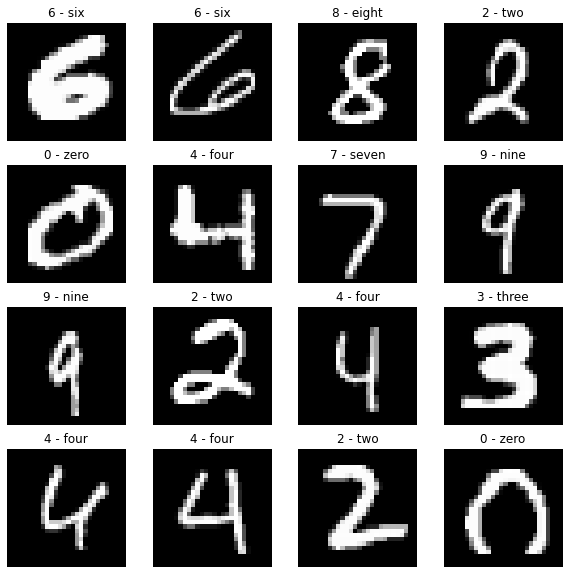

In [6]:
# Plot 16 random images from our dataset
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
torch.manual_seed(SEED)

for i in range(1, rows*cols+1):

    # get a random index
    random_idx = torch.randint(0, len(train_data), size=[1]).item()

    # get image and lable from index
    img, label = train_data[random_idx]

    # add image to subplot in grayscale
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## **Helper Functions**

In [7]:
# Calculates accuracy between truth labels and predictions
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [8]:
# Prints difference between start and end time
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

In [9]:
def training(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             optimizer: torch.optim.Optimizer,
             accuracy_fn,
             device: torch.device = device):
    
    """Performs a training with model trying to learn on data_loader"""

    # Metrics
    train_loss, train_acc = 0, 0

    # Send model to taget device
    model.to(device)

    # Put model into training mode
    model.train()

    # Start training loop
    for (X, y) in data_loader:

        # Send data to target device 
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logits = model(X)
        y_pred = y_logits.argmax(dim=1)

        # 2. Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss

        # 3. Calculate accuracy
        acc = accuracy_fn(y_pred, y)
        train_acc += acc

        # 4. Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
  
    # Get average metric per batch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    # Progress tracking
    print(f"Train loss: {train_loss:.4f}  |  Train acc: {train_acc:.1f}%")

In [10]:
def testing(model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader, 
            loss_fn: torch.nn.Module,
            accuracy_fn,
            device: torch.device = device,
            output: bool = True):
    
    """Performs a testing loop step on model going over data_loader"""

    # Start the timer
    time_start = timer()

    # Metrics
    test_loss, test_acc = 0, 0

    # Send model to taget device
    model.to(device)

    # Put model into evaluation mode
    model.eval()

    # Start testing loop
    with torch.inference_mode():
        for (X, y) in data_loader:

            # Send data to target device 
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_logits = model(X)
            y_pred = y_logits.argmax(dim=1)

            # 2. Calculate loss
            loss = loss_fn(y_logits, y)
            test_loss += loss

            # 3. Calculate accuracy
            acc = accuracy_fn(y_pred, y)
            test_acc += acc

         # Get average metric per batch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    # Progress Tracking
    if output: print(f"Test loss: {test_loss:.5f}  |  Test acc: {test_acc:.2f}%")

    # Stop the timer
    time_end = timer()

    return {
        "model_name": model.__class__.__name__, 
        "model_loss": test_loss.item(),
        "model_acc": test_acc,
        "test_time": time_end - time_start
    }

## **Convolutional Neural Network**

In [11]:
class DigitModel(nn.Module):

    """Model architecture that replicates the TinyVGG model from CNN explainer website."""

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels = input_shape, 
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1,
            ), 
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features = hidden_units * 7 * 7, #  dimensional analysis
                out_features=output_shape
            )
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x) 
        x = self.classifier(x)
        return x

In [12]:
# Reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Create instance
model = DigitModel(
    input_shape = 1, # color channels
    hidden_units = HIDDEN,
    output_shape = len(class_names)
)

# Send model to target device
model.to(device)

# Show Architecture
print(f"{model} device: {next(model.parameters()).device}")

DigitModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
) device: cpu


## **Dimensional Analysis**

In [13]:
# layers
input_layer = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)
conv_layer = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)
relu_layer = nn.ReLU()
pooling_layer = nn.MaxPool2d(kernel_size = 2)
flatten_layer =  nn.Flatten()
linear_layer = nn.Linear(in_features = 10*7*7, out_features=10)

# computations
image = torch.rand(1, 1, 28, 28)
conv1 = input_layer(image)
relu1 = relu_layer(conv1)
conv2 = conv_layer(relu1)
relu2 = relu_layer(conv2)
pool1 = pooling_layer(relu2)
conv3 = conv_layer(pool1)
relu3 = relu_layer(conv3)
conv4 = conv_layer(relu3)
relu4 = relu_layer(conv4)
pool2 = pooling_layer(relu4)
flat = flatten_layer(pool2)
output = linear_layer(flat)

print(
f'''
Tiny VGG Architecture

Input Layer
image: {list(image.size())}

Convolutional Block 1
conv1: {list(conv1.size())}
relu1: {list(relu1.size())}
conv2: {list(conv2.size())}
relu2: {list(relu2.size())}
pool1: {list(pool1.size())}

Convolutional Block 2
conv3: {list(conv3.size())}
relu3: {list(relu3.size())}
conv4: {list(conv4.size())}
relu4: {list(relu4.size())}
pool2: {list(pool2.size())}

Classifier Block
flat:  {list(flat.size())}
out:   {list(output.size())}
'''
)



Tiny VGG Architecture

Input Layer
image: [1, 1, 28, 28]

Convolutional Block 1
conv1: [1, 10, 28, 28]
relu1: [1, 10, 28, 28]
conv2: [1, 10, 28, 28]
relu2: [1, 10, 28, 28]
pool1: [1, 10, 14, 14]

Convolutional Block 2
conv3: [1, 10, 14, 14]
relu3: [1, 10, 14, 14]
conv4: [1, 10, 14, 14]
relu4: [1, 10, 14, 14]
pool2: [1, 10, 7, 7]

Classifier Block
flat:  [1, 490]
out:   [1, 10]



## **Training & Testing**

In [14]:
# Reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup loss function
loss_fn = nn.CrossEntropyLoss() 

# Setup optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

# Start the timer
time_start = timer()

# Training & testing loop
for epoch in tqdm(range(EPOCHS)):

    print(f"\nEpoch: {epoch}")

    training(
        model = model,
        data_loader = train_dataloader,
        loss_fn = loss_fn,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn,
    )
  
    testing(
        model = model,
        data_loader = test_dataloader,
        loss_fn = loss_fn,
        accuracy_fn = accuracy_fn,
    )

    print(f"{'_'*45}")

# Stop the timer
time_end = timer()

# Calculate training time
train_time = print_train_time(time_start, time_end, device)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train loss: 0.3356  |  Train acc: 88.7%
Test loss: 0.07362  |  Test acc: 97.71%
_____________________________________________

Epoch: 1
Train loss: 0.0822  |  Train acc: 97.4%
Test loss: 0.06596  |  Test acc: 97.95%
_____________________________________________

Epoch: 2
Train loss: 0.0644  |  Train acc: 98.0%
Test loss: 0.05947  |  Test acc: 98.04%
_____________________________________________

Epoch: 3
Train loss: 0.0559  |  Train acc: 98.2%
Test loss: 0.06140  |  Test acc: 97.92%
_____________________________________________

Epoch: 4
Train loss: 0.0498  |  Train acc: 98.4%
Test loss: 0.04684  |  Test acc: 98.39%
_____________________________________________

Train time on cpu: 270.989 seconds


## **Evaluation**

In [15]:
# Display model metrics
results = testing(model, test_dataloader, loss_fn, accuracy_fn, output=False)

print(
f'''
Model Name:      {results["model_name"]}
Model Loss:      {results["model_loss"]:.5f}
Model Accuracy:  {results["model_acc"]:.2f} %
Training Time:   {train_time:.2f} seconds
Testing Time:    {results["test_time"]:.2f} seconds
'''
)


Model Name:      DigitModel
Model Loss:      0.04684
Model Accuracy:  98.39 %
Training Time:   270.99 seconds
Testing Time:    4.00 seconds



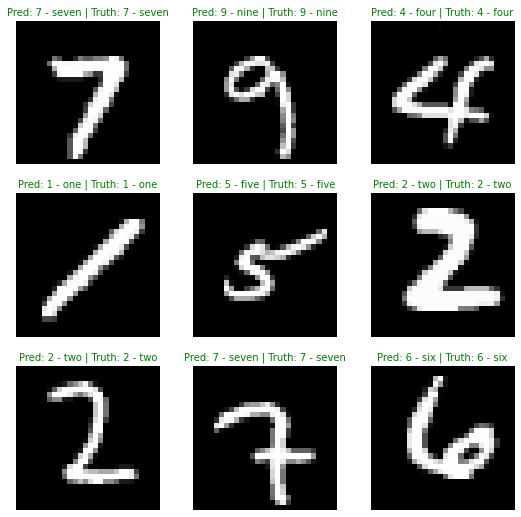

In [16]:
# Pick 9 random images from the test dataset and plot the predictions

test_images, test_labels = [], []
plt.figure(figsize=(9, 9))
rows, columns = 3, 3
counter = 0

for image, image_lable in random.sample(list(test_data), k=9):

    # Update counter
    counter +=1

    # Prepare image
    image = torch.unsqueeze(image, dim=0).to(device)

    # Classify image
    pred_logit = model(image)
    pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
    pred_label = pred_prob.argmax().cpu()
    pred_class =  class_names[pred_label]

    # Get true class
    image_class = class_names[image_lable]
  
    # Add image to subplot
    plt.subplot(rows, columns, counter)

    # Plot the target image
    plt.imshow(image.squeeze(), cmap="gray")

    # Create a title for the plot
    title_text = f"Pred: {pred_class} | Truth: {image_class}"

    # Check for equality between pred and truth and change color of title text
    if pred_class == image_class: plt.title(title_text, fontsize=10, c="g") 
    else: plt.title(title_text, fontsize=10, c="r") 
    plt.axis(False);

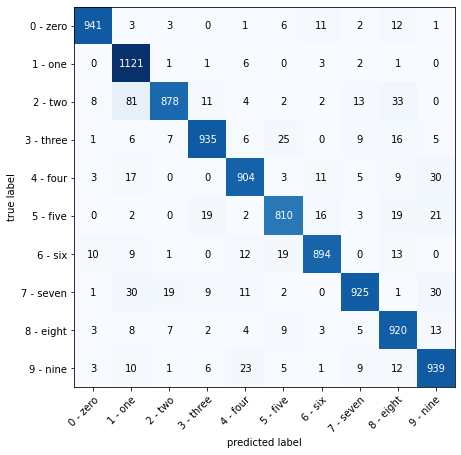

In [17]:
# Diplay confusion matrix

y_preds = []
model.eval()

# Make prediction with model
with torch.inference_mode():
  for X, y in test_dataloader:

    # Send both data and model to target device
    X, y, model = X.to(device), y.to(device), model.to(device)

    # Classify Image
    y_logit = model(X)
    y_prob = torch.softmax(y_logit.squeeze(), dim=0)
    y_lable = y_prob.argmax(dim=1).cpu()

    # Add to prediction array
    y_preds.append(y_lable)

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), 
    class_names = class_names,
    figsize = (10, 7)
)

## Saving Model

In [18]:
# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save
MODEL_NAME = "handwritten-digit-recognition.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/handwritten-digit-recognition.pth
